# 18.065 Problem Set 4 Solutions

## Problem 1 (5+5 points)

A "convex set" $S$ is one such that for any two points $x,y$ in $S$, the straight line connecting them is also in $S$.  That is, $\alpha x + (1-\alpha)y \in S$ for all $\alpha \in [0,1]$.

**(a)** If $f_i(x)$ is a [convex function](https://en.wikipedia.org/wiki/Convex_function) (as defined in e.g. lecture 16), explain why the constraint $f_i(x) \le 0$ defines a convex set of feasible points.

**(b)** Explain why the intersection of two convex sets is a convex set.  (Hence, the feasible set for many convex constraints is a convex set.)

### Solution:

**(a)** Suppose $x$ and $y$ are feasible, i.e. $f_i(x) \le 0$ and $f_i(y) \le 0$.  Then, by the definition from class of convex functions, we have:
$$
f_i(\alpha x + (1-\alpha) y) \le \alpha f_i(x) + (1-\alpha) f_i(y) \le 0
$$
for any $\alpha \in [0,1]$, which means that $\alpha x + (1-\alpha) y$ is feasible.  So, the feasible set is convex.

**(b)** If $S$ is convex and $T$ is convex, then consider their intersection $S \cap T$.  $x, y \in S \cap T$ means that $x, y \in S$ and $x,y \in T$, by the definition of intersection.   But since $S,T$ are convex, this means that $\alpha x + (1-\alpha) y$ is $\in S$ and $\in T$, so it's also in $S \cap T$.  Hence $S \cap T$ is convex.

## Problem 2 (10 points)

Suppose we are solving the $\ell^1$-regularized least-square problem:
$$
\min_{x\in \mathbb{R}^n} \left( \Vert b - Ax \Vert_2^2 + \lambda \Vert x \Vert_1 \right)
$$
where $\lambda > 0$ is some regularization parameter and $ \Vert x \Vert_1 = \sum_i |x_i|$ is the $\ell^1$ norm.

Similar to the examples in 16, show that this can be converted into a an equivalent [quadratic programming (QP)](https://en.wikipedia.org/wiki/Quadratic_programming) problem — a convex quadratic objective with affine constraints — by introducing one or more dummy variables (an "epigraph" formulation).   This replaces the non-differentiable $\ell^1$ problem with an equivalent *differentiable* problem with *differentiable constraints*.

### Solution:

We just need to apply the epigraph trick to *every term*.  That is, suppose we introduce $n$ dummy variables $t \in \mathbb{R}^n$, and solve:
$$
\min_{x,t\in \mathbb{R}^n} \left( \Vert b - Ax \Vert_2^2 + \sum_{i=1}^n t_i \right)
$$
subject to the $2n$ affine constraints:
$$
t_i \ge \lambda x_i \, \qquad t_i \ge -\lambda x_i
$$
which will force $t_i = \lambda |x_i|$ at the minimum.  This is a [QP: a convex quadratic objective function + affine constraints](https://en.wikipedia.org/wiki/Quadratic_programming).

## Problem 3 (5 + 5 points)

Let
$$
A(p) = A_0 + \underbrace{\begin{pmatrix} p_1 & & & \\ & p_2 & & \\ & & \ddots & \\ & & & p_m \end{pmatrix}}_{\text{diagm(p)}}
$$
where $A_0$ is some $m \times m$ matrix and $p \in \mathbb{R}^m$ are $m$ parameters.

Now, suppose we compute
$$
f(p) = g(\underbrace{A(p)^{-1} b}_{x(p)})
$$
where $g(x) = x^T G x$, $b \in \mathbb{R}^m$ is some vector, and $G = G^T$ is some symmetric $m \times m$ matrix.

**(a)** What is $\nabla f$?  Explain how you can compute *all m* components of $\nabla f$ by solving only *two* $m \times m$ systems followed by $\Theta(m)$ additional work in *total*.  *Clarification*: What I really want is for you to show that, in addition to the cost of computing $f(p)$ (which involves solving one system $Ax=b$), the additional work to compute $\nabla f$ only involves solving one more system plus $\Theta(m)$ arithmetic.

**(b)** Implement your solution from (a) by filling in the function `∇f(p)` below, and check that it correctly predicts $df = f(p + dp) - f(p)$ (*approximately*) for a random small $dp$.

### Solution:

In [31]:
using LinearAlgebra

# some A₀, b, G for m=5
m = 5
A₀ = randn(m,m)
b = randn(m)
G = randn(m,m); G = G' + G

# our functions
g(x) = x' * G * x
f(p) = g((A₀ + Diagonal(p)) \ b)

p = randn(m) # some random parameters
f(p) # make sure it gives a number out

-8.034026689349616

**(a)**

As explained in class (lecture 18) for a very similar problem, by the chain rule and the formula $d(A^{-1}) = -A^{-1} dA \, A^{-1}$, we have:
$$
df = \nabla g^T dx = \underbrace{-\nabla g^T A^{-1}}_{v^T} dA \, \underbrace{A^{-1} b}_x
$$
and so
$$
\frac{\partial f}{\partial p_i} = v^T \frac{\partial A}{\partial p_i} x
$$
where $v$ solves $A^T v = -\nabla g$ (the "adjoint" equation), and $\frac{\partial A}{\partial p_i}$ is just the matrix of all 0's except for a single 1 in the $i,i$ diagonal entry.

So, to compute $\nabla f$, we just need to do:

1. Compute $x$ by solving $Ax=b$ and $\nabla g = 2Gx$.  (We need both $x$ and $Gx$ to compute $f$ in the first place, so this is "free").  
2. Solve $A^T v = -\nabla g = -2Gx$: this is *one* additional system of the same size.
3. Compute the dot products $v^T \frac{\partial A}{\partial p_i} x = v_i x_i$ for $i = 1,\ldots,m$.  This is $\Theta(m)$ work: in Julia notation, we are just computing the elementwise product $\nabla f = v \mbox{ .* } x$.

**(b)** The above algorithm is implemented as follows.

To check that our $\nabla f$ is correct, we simply want to check that our finite-difference `df` (for a small random `dp`) is $\approx \nabla f^T dp$.  (The match won't be exact because `dp` is not infinitesimal.)

In [33]:
# your solution to (b):

function ∇f(p)
    # in a practical setting, we would re-use this
    # from the f(p) computation:
    A = A₀ + Diagonal(p)
    x = A \ b
    ∇g½ = G*x
    
    # adjoint equation:
    # (in practice you might re-use the LU factorization of A!)
    v = A' \ (-2∇g½)
    
    ∇f = v .* x # elementwise products, from vᵀ(∂A/∂pᵢ)x
end

dp = randn(m) * 1e-8 # a random small dp
df = f(p + dp) - f(p)

# check: ∇f approximately predicts df
@show df         # finite-difference approximation
@show ∇f(p)'dp   # gradient prediction

df = 1.404071513277927e-6
(∇f(p))' * dp = 1.4040715903119016e-6


1.4040715903119016e-6

Yup, they match to about 8 significant digits, which is about as much as we can hope for given a finite $dp \sim 10^{-8}$.

## Problem 4 (5+5+5 points)

In class, we considered steepest descent for $f(x) = \kappa x_1^2 + x_2^2$ in $\mathbb{R}^2$, and argued that for an arbitrary $x = [x_1,x_2]$ starting point and $\kappa \gg 1$, the steepest-descent step $x \leftarrow x - sz$ is *approximately* $sz \approx [x_1, x_2/\kappa]$.

### Part (a):

**(a)** If $sz = [x_1, x_2/\kappa]$ exactly, then on the next step we would have the new $x \leftarrow x - sz = [0, (1-\frac{1}{\kappa}) x_2)]$.   However, explain why a more careful calculation shows that the new $x - sz \approx [O(1/\kappa^2), x_2-\frac{1}{\kappa} x_2 + O(1/\kappa^3)]$, i.e. the first component is proportional to $1/\kappa^2$ to leading order in $1/\kappa$.

### Solution:

From class, each step is $x \to x - sz$ where $z = Ax = [\kappa x_1, x_2]$ and
$$
s = \frac{z^T z}{z^T A z} = \frac{\kappa^2 x_1^2 + x_2^2}{\kappa^3 x_1^2 + x_2^2} = \kappa^{-1} \frac{ 1 + (x_2/x_1)^2 \kappa^{-2}}{1 + (x_2/x_1)^2 \kappa^{-3}}
$$
Taylor expanding in $\kappa^{-1}$, we obtain:
$$
s \approx \kappa^{-1} + (x_2/x_1)^2 \kappa^{-3} + O(\kappa^{-4})
$$
Hence
$$
x - sz \approx \begin{pmatrix} x_1 - (1 + (x_2/x_1)^2 \kappa^{-2} + O(\kappa^{-3}))x_1 \\ x_2 - \kappa^{-1} x_2 + O(\kappa^{-3}) \end{pmatrix}
= \begin{pmatrix} - (x_2^2/x_1) \kappa^{-2} + O(\kappa^{-3}) \\ (1 - \kappa^{-1}) x_2 + O(\kappa^{-3}) \end{pmatrix}
$$
which is of the suggested form.

### Part (b):

**(b)** If you start with an $x = [\#/\kappa^2, x_2]$, i.e. where the first component is proportional to $1/\kappa^2$ and $\#$ is some number of the same order of magnitude as $x_2$, show that after one steepest-descent step (for $\kappa \gg 1$) the $x_1$ component is *still* roughly order $1/\kappa^2$ but of the opposite sign, and $x_2$ again subtracts a term roughly proportional to $x_2/\kappa$.

### Solution:

Conversely, if $x_1 = \# / \kappa$, we have $x_2/x_1 = \kappa (x_2 / \#)$ and $s$ becomes:
$$
s = \kappa^{-1} \frac{ 1 + (x_2/x_1)^2 \kappa^{-2}}{1 + (x_2/x_1)^2 \kappa^{-3}} = \kappa^{-1} \frac{ 1 + (x_2 / \#)^2}{1 + (x_2 / \#)^2 \kappa^{-1}} \approx \kappa^{-1} (1 + (x_2 / \#)^2) + O(\kappa^{-2})
$$
So our steepest-descent step becomes, to leading order in $1/\kappa$:
$$
x - sz \approx  \begin{pmatrix} -(x_2 / \#)^2 \kappa^{-1}  \\ x_2 \left[1 - \kappa^{-1} (1 + (x_2 / \#)^2)\right]  \end{pmatrix}
$$
i.e. the first term is still of order $1/\kappa$ but with the opposite sign, and the second term has shrunk by a term of $O(x_2 / \kappa)$.   

It is **zig-zagging slowly towards the solution!**

**Optional**:

We can also analyze the case that we get after one step, in part (a):

If $x_1 = \# / \kappa^2$, we have to re-do our calculation of $s$, since $x_2/x_1 = \kappa^2 (x_2 / \#)$:
$$
s = \kappa^{-1} \frac{ 1 + (x_2/x_1)^2 \kappa^{-2}}{1 + (x_2/x_1)^2 \kappa^{-3}} = \kappa^{-1} \frac{ 1 + (x_2 / \#)^2 \kappa^{2}}{1 + (x_2 / \#)^2 \kappa} \approx 1 - (\# / x_2)^2 \kappa^{-1} +  O(\kappa^{-2})
$$
So our steepest-descent step becomes, to leading order in $1/\kappa$:
$$
x - sz \approx \kappa^{-1} \begin{pmatrix} -\#  \\ +x_2(\# / x_2)^2   \end{pmatrix}
$$
i.e. *both* terms are of order $\kappa^{-1}$, with the first term having an opposite sign from what it started with.

(So, if this is the second iteration, then we are roughly back where we started but we gained a factor of $\kappa^{-1}$.  That means, for this starting point it actually converges *much* faster, gaining about a factor of $\kappa^{-1}$. every 2 iterations.   Not every starting point zig-zags!   But we are mainly interested in the *worst-case* convergence since we can't count on getting lucky with our initial guess.)

### Part (c):

**(c)** Implement this steepest-descent process numerically for $\kappa = 100$ and a starting point $x_1 = 0.01234567$ and $x_2 = 0.8910$.  Plot $100x_1$ and $x_2$ for 100 iterations of steepest descent.  A more careful analysis would show a convergence proportional to $\left( \frac{\kappa - 1}{\kappa + 1} \right)^k$, where $k$ is the iteration number, following equation (4) in the Strang book — include this function for comparison on your plot.

### Solution:

Since $x_1$ is of order $1/\kappa$, we expect something similar to the second case in part (b): from one iteration to the next, it should stay of roughly the same order but flip sign, and both components should asymptotically shrink slowly following equation (4):

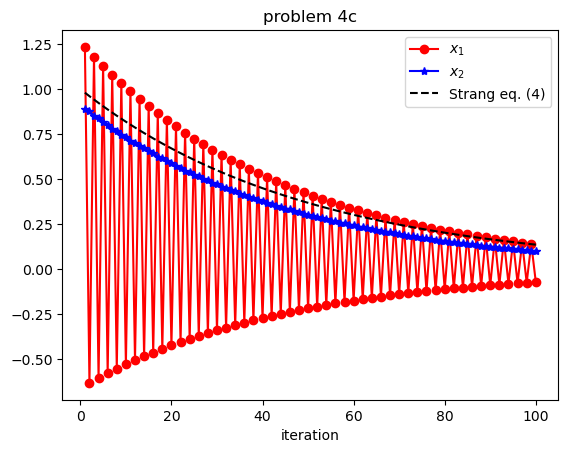

PyObject <matplotlib.legend.Legend object at 0x296e625b0>

In [28]:
x = [0.01234567, 0.8910] # starting guess
κ = 100
A = [ κ 0
      0 1 ]
xvals = [ x ] # list of x values
for k = 2:100
    z = A*x
    s = z'z / (z'*A*z) # = (κ^2*x[1]^2 + x[2]^2) / (κ^3*x[1]^2 + x[2]^2)
    x = x - s*z
    push!(xvals, x)
end

using PyPlot
plot(1:100, getindex.(xvals,1) * κ, "ro-")
plot(1:100, getindex.(xvals,2), "b*-")
plot(1:100, ((κ-1)/(κ+1)).^(1:100), "k--")
xlabel("iteration")
title("problem 4c")
legend([L"x_1", L"x_2", "Strang eq. (4)"])

## Problem 5 (10 points)

In the Adam algorithm for stochastic optimization, we keep a "running average" ("1st moment") $m^{(k)}$ of the estimated gradients.  If $\tilde{\nabla}f^{(k)}$ is our estimated (mini-batch) gradient at $x^{(k)}$ (the k-th step, for $k=1,2,3,\ldots$), then the running average is computed as:
$$
m^{(k)} = \beta_1 m^{(k-1)} + (1-\beta_1) \tilde{\nabla}f^{(k)} \, ,
$$
where $0 \le \beta_1 < 1$ (typically $\beta_1 = 0.9$) is a given weight, and we define $m^{(0)} = \vec{0}$.

However, before we use the gradient to take a step, we "de-bias" it to:
$$
\hat{m}^{(k)} = \frac{m^{(k)}}{1 - \beta_1^k}
$$
**Explain** why $\hat{m}^{(k)}$ is exactly a weighted average of the estimates $\tilde{\nabla}f^{(j)}$ for $j = 1,\ldots,k$ — that is, explain why dividing by $1 - \beta_1^k$ exactly corresponds to dividing by the sum of the weights of each $\tilde{\nabla}f^{(j)}$ term.  (The formulas for the [sum of a geometric series](https://en.wikipedia.org/wiki/Geometric_series) will be helpful.)

### Solution:

Just expanding out the formula (with $m^{(0)} = 0$ — there is no momentum to start with), we get:
$$
m^{(k)} = \beta_1 m^{(k-1)} + (1-\beta_1) \tilde{\nabla}f^{(k)} \\
= \beta_1^2 m^{(k-2)} + \beta_1 (1-\beta_1) \tilde{\nabla}f^{(k-1)}  + (1-\beta_1) \tilde{\nabla}f^{(k)} \\
= \beta_1^3 m^{(k-3)}  + \beta_1^2 (1-\beta_1) \tilde{\nabla}f^{(k-2)} + \beta_1 (1-\beta_1) \tilde{\nabla}f^{(k-1)}  + (1-\beta_1) \tilde{\nabla}f^{(k)}
= \cdots \\
= (1-\beta_1) \sum_{i=0}^{k-1} \beta_1^i \tilde{\nabla}f^{(k-i)} \, .
$$
The sum of all the coefficients is, using the usual formula for a finite geometric series:
$$
(1-\beta_1) \sum_{i=0}^{k-1} \beta_1^i = (1-\beta_1) \frac{1 - \beta_1^k}{1-\beta_1} = 1 - \beta_1^k \, .
$$
So, $1 - \beta_1^k$ is *exactly* the what we would divide by to make $\hat{m}^{(k)}$ correspond to simply a weighted average of all the $\tilde{\nabla}f^{(k-i)}$ values. 

## Problem 6 (10 points)

The Julia notebook from class (lecture 21) implemented the Adam algorithm for stochastic optimization.  This code is reproduced below.

A more recent algorithm, that has better convergence guarantees than Adam, is called [YOGI (Zaheer et al., 2018)](https://papers.nips.cc/paper_files/paper/2018/hash/90365351ccc7437a1309dc64e4db32a3-Abstract.html).   Make a copy of the code below and **modify it to implement the YOGI algorithm** as described in algorithm 2 of the linked paper.  (This algorithm omits the "de-biasing" step of problem 5, but you should include that in your implementation; the de-biasing is identical to that of Adam.)   **Plot the convergence** of YOGI for this problem, with the same hyper-parameters, along with the original Adam algorithms (using different colors superimposed on a single plot).

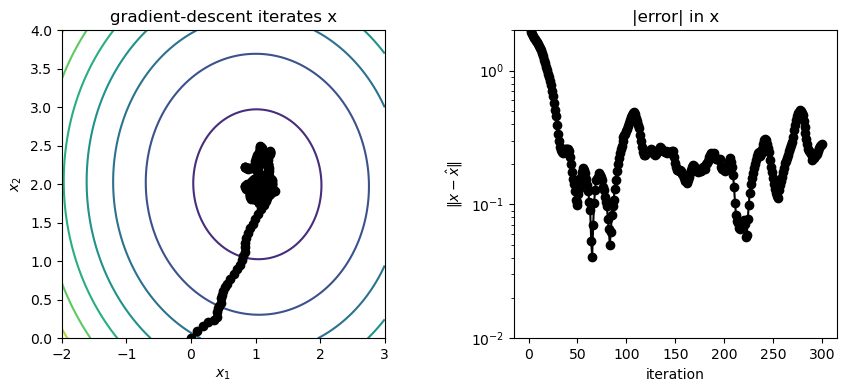

PyObject Text(0.5, 1.0, '|error| in x')

In [64]:
using LinearAlgebra, PyPlot, Random

# typical Adam hyper-parameters
ϵ = 1e-8
β₁ = 0.9
β₂ = 0.999

# more parameters
log₁₀α = -1
α = exp10(log₁₀α) # approx. maximum stepsize |Δx|
M = 1 # mini-batch size
iterations = 300

Random.seed!(314159)

x̂₀ = [1,2] # ground-truth model
x = [0.0,0.0]
X = [x]
ΔX = [norm(x - x̂₀)]
m = zero(x) # initial 1st-moment (mean gradient)
v = zero(x) # initial 2nd-moment (mean gradient.^2)
for t = 1:iterations
    # generate a mini-batch of size M:
    ã = randn(M)
    b̃ = @. 1 + 2ã + randn()
    Ã = [one.(ã) ã]

    # approximate gradient from this mini-batch
    ∇f̃ = (2/M)*(Ã'*(Ã*x - b̃))

    # Adam update
    m = β₁*m + (1-β₁)*∇f̃
    v = β₂*v + (1-β₂)*(∇f̃.^2)
    m̂ = m / (1 - β₁^t) # de-bias: normalize by total weights
    v̂ = v / (1 - β₂^t) # de-bias: normalize by total weights
    x = @. x - α * m̂ / (√v̂ + ϵ)

    push!(X, x)
    push!(ΔX, norm(x - x̂₀))
end

# objective function for contour plot:
a = randn(1000)
b = @. 1 + 2a + randn()
A = [one.(a) a]
f(x) = norm(b-A*x)^2 / length(b)
f(x1,x2) = f([x1,x2])
x1 = range(-2,3, length=100)
x2 = range(0,4,length=100)
fvals = f.(x1',x2)

# plot progress

figure(figsize=(10,4))

subplot(1,2,1)
plt.subplots_adjust(wspace=0.4)
contour(x1', x2, fvals)
plot(x̂₀[1], x̂₀[2], "r*")
plot(getindex.(X,1), getindex.(X,2), "ko-")
xlabel(L"x_1")
ylabel(L"x_2")
title("gradient-descent iterates x")

subplot(1,2,2)
semilogy(ΔX, "ko-")
ylim(1e-2, 2)
xlabel("iteration")
ylabel(L"\Vert x - \hat{x} \Vert")
title("|error| in x")

### Solution:

The only difference from Adam is the update of the "variance" estimate,
which is now:
$$
v^{(k)} = \beta_2 v^{(k-1)} - (1 - \beta_2) \underbrace{\text{sign}.(v^{(k-1)} - g^{(k)}\mbox{.^2})}_\mbox{new} \mbox{ .* }g^{(k)}\mbox{.^2}
$$
where $g^{(k)} = \tilde{\nabla} f^{(k)}$ is the estimated (mini-batch) gradient, the [sign function](https://docs.julialang.org/en/v1/base/math/#Base.sign) is ±1 depending on the sign of each element, and all the multiplications are taken elementwise (denoted with a `.` in Julia notation).  Note also the minus sign in front of the second term.

(In Julia, we can simply make *everything* elementwise in a line of code by putting `@.` before the calculation.)

This is implemented below.  In order to compare it quantitatively to Adam, we want to do things:

1. Plot the Adam and Yogi results on the same plot.
2. To make the comparison more exact, use the *same "random" numbers* for both (i.e. the same mini-batches).  (Otherwise we will get iterations that are qualitatively similar but quantitatively quite different.)

One way to do the latter is to merge the loops — perform both the Adam and Yogi updates in the same loop, and save the iterates in different variables.  An even more slick way to do this is to use the [`Random.seed!`](https://docs.julialang.org/en/v1/stdlib/Random/#Random.seed!) function to set a deterministic [seed](https://en.wikipedia.org/wiki/Random_seed) for the random-number generator.  This allows us to generate the same "random" numbers both times.  We can pick any seed we want, but I used `Random.seed!(314159)`:

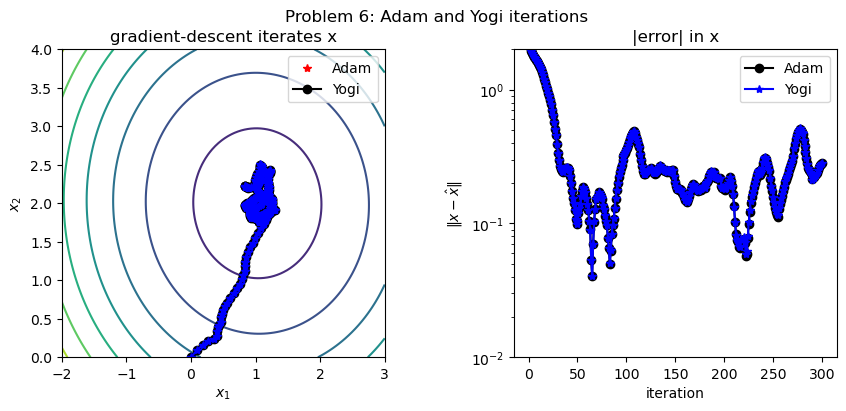

PyObject Text(0.5, 1.0, '|error| in x')

In [75]:
Random.seed!(314159)

x = [0.0,0.0]
X_yogi = [x]
ΔX_yogi = [norm(x - x̂₀)]
m = zero(x) # initial 1st-moment (mean gradient)
v = zero(x) # initial 2nd-moment (mean gradient.^2)
for t = 1:iterations
    # generate a mini-batch of size M:
    ã = randn(M)
    b̃ = @. 1 + 2ã + randn()
    Ã = [one.(ã) ã]

    # approximate gradient from this mini-batch
    ∇f̃ = (2/M)*(Ã'*(Ã*x - b̃))

    # Adam update
    m = β₁*m + (1-β₁)*∇f̃
    v = @. β₂*v - (1-β₂) * sign(v - ∇f̃^2) * (∇f̃^2)
    m̂ = m / (1 - β₁^t) # de-bias: normalize by total weights
    v̂ = v / (1 - β₂^t) # de-bias: normalize by total weights
    x = @. x - α * m̂ / (√v̂ + ϵ)

    push!(X_yogi, x)
    push!(ΔX_yogi, norm(x - x̂₀))
end


# plot progress

figure(figsize=(10,4))
plt.suptitle("Problem 6: Adam and Yogi iterations")

subplot(1,2,1)
plt.subplots_adjust(wspace=0.4)
contour(x1', x2, fvals)
plot(x̂₀[1], x̂₀[2], "r*")
plot(getindex.(X,1), getindex.(X,2), "ko-")
plot(getindex.(X_yogi,1), getindex.(X_yogi,2), "b*-")
legend(["Adam", "Yogi"])
xlabel(L"x_1")
ylabel(L"x_2")
title("gradient-descent iterates x")

subplot(1,2,2)
semilogy(ΔX, "ko-")
semilogy(ΔX_yogi, "b*-")
ylim(1e-2, 2)
legend(["Adam", "Yogi"])
xlabel("iteration")
ylabel(L"\Vert x - \hat{x} \Vert")
title("|error| in x")

When we plot them like this, we can see that there is virtually no difference!  That's **because this example problem is so well-conditioned** (the $f$ contours are nearly circles), so the momentum terms make almost no difference — momentum-based algorithms should be essentially equivalent to steepest descent for well-conditioned problems.

**Optional**:

To actually see any difference between the iterates, let's plot the difference $\Vert x_\text{Adam} - x_\text{Yogi} \Vert$:

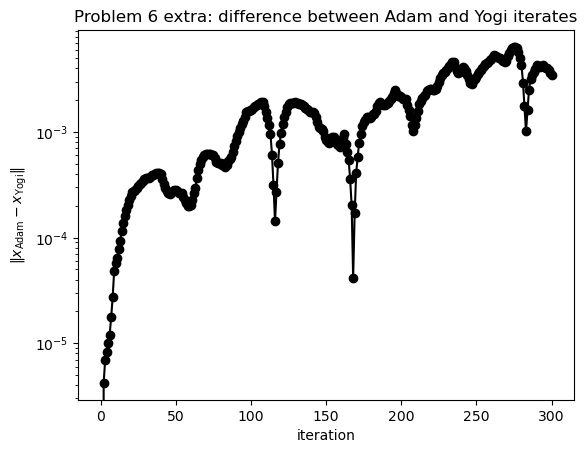

PyObject Text(0.5, 1.0, 'Problem 6 extra: difference between Adam and Yogi iterates')

In [77]:
semilogy(norm.(X .- X_yogi), "ko-")
xlabel("iteration")
ylabel(L"\Vert x_\mathrm{Adam} - x_\mathrm{Yogi} \Vert")
title("Problem 6 extra: difference between Adam and Yogi iterates")

The differences are bigger than roundoff errors, but they are still quite small!